# Analysis of comment moderation results (A/B/C policies)

This notebook:
- Loads:
  - `../data/comments.csv`
  - `../results/comments_with_policy_results.csv`
- Computes:
  - Overall distribution of decisions (BLOCK / WARN_AND_ALLOW / ALLOW) per policy
  - Average tone and debate-value scores per policy
  - Cases where policies disagree (e.g., A=BLOCK, C=ALLOW)
- Produces:
  - Summary tables (for slides / report)
  - Optional simple visualizations (bar charts) using matplotlib

Assumptions:
- Notebook is located in `notebooks/` directory of the project.
- Folder structure:

    project_root 
             
      ├─ data/ 
      
      │   └─ comments.csv 
      
      ├─ results/ 
      
      │   └─ comments_with_policy_results.csv 
      
      └─ notebooks/ 
      
          └─ analysis_comments_results.ipynb (this file) 

In [1]:
# Standard imports
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Set up paths assuming this notebook is in `notebooks/`
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"

COMMENTS_CSV = DATA_DIR / "comments.csv"
RESULTS_CSV = RESULTS_DIR / "comments_with_policy_results.csv"

print("Project root :", PROJECT_ROOT)
print("Comments CSV :", COMMENTS_CSV)
print("Results CSV  :", RESULTS_CSV)


Project root : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_jayu
Comments CSV : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_jayu\data\comments.csv
Results CSV  : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_jayu\results\comments_with_policy_results.csv


In [2]:
# Load original comments (one row per sample_id)
comments_df = pd.read_csv(COMMENTS_CSV)
print(f"Loaded {len(comments_df)} rows from comments.csv")
display(comments_df.head())

# Load policy results (one row per sample_id x policy)
results_df = pd.read_csv(RESULTS_CSV)
print(f"Loaded {len(results_df)} rows from comments_with_policy_results.csv")
display(results_df.head())


Loaded 182 rows from comments.csv


,sample_id,thread_id,role,order_in_thread,text
0,1,1,post,0,얼마나 인기없으면 글이 안올라오냐
1,2,1,comment,1,뭐?
2,3,1,comment,2,?
3,4,2,post,0,그냥 궁금해서 하는 투표 AI 쓰면 안되는 시험/과제에서 솔직히 쓴 적 있다/없다 ...
4,5,2,comment,1,과제는 많이들 ai 조금이라도 써봤을듯


Loaded 546 rows from comments_with_policy_results.csv


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score
0,1,1,post,0,A,WARN_AND_ALLOW,"강한 비판이지만 특정 인물에 대한 직접적인 모욕이 아니며, 시스템이나 정책에 대한 ...",3,2
1,1,1,post,0,B,WARN_AND_ALLOW,"강한 표현이지만 특정 개인에 대한 직접적인 공격이 아니고, 시스템이나 상황에 대한 ...",3,2
2,1,1,post,0,C,ALLOW,"명확한 위협이나 혐오 표현이 없으며, 자유로운 비판 표현으로 판단됨.",3,2
3,2,1,comment,1,A,ALLOW,"단어 자체가 무례하거나 공격적이지 않고, 인신공격이나 혐오 표현이 없음.",2,1
4,2,1,comment,1,B,ALLOW,"비판적 표현이나 욕설이 없으며, 토론에 기여하는 내용은 적지만 무해함.",2,1


In [3]:
# Merge results with original text so that every row has the comment text
merged_df = results_df.merge(
    comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
    on=["sample_id", "thread_id", "role", "order_in_thread"],
    how="left",
    suffixes=("", "_orig"),
)

print(f"Merged rows: {len(merged_df)}")
display(merged_df.head())


Merged rows: 546


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score,text
0,1,1,post,0,A,WARN_AND_ALLOW,"강한 비판이지만 특정 인물에 대한 직접적인 모욕이 아니며, 시스템이나 정책에 대한 ...",3,2,얼마나 인기없으면 글이 안올라오냐
1,1,1,post,0,B,WARN_AND_ALLOW,"강한 표현이지만 특정 개인에 대한 직접적인 공격이 아니고, 시스템이나 상황에 대한 ...",3,2,얼마나 인기없으면 글이 안올라오냐
2,1,1,post,0,C,ALLOW,"명확한 위협이나 혐오 표현이 없으며, 자유로운 비판 표현으로 판단됨.",3,2,얼마나 인기없으면 글이 안올라오냐
3,2,1,comment,1,A,ALLOW,"단어 자체가 무례하거나 공격적이지 않고, 인신공격이나 혐오 표현이 없음.",2,1,뭐?
4,2,1,comment,1,B,ALLOW,"비판적 표현이나 욕설이 없으며, 토론에 기여하는 내용은 적지만 무해함.",2,1,뭐?


In [4]:
# ---- 1. Decision distribution per policy ----
decision_summary = (
    merged_df
    .groupby(["policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print("Decision counts per policy:")
display(decision_summary)

# Also compute row-wise percentages
decision_pct = decision_summary.div(decision_summary.sum(axis=1), axis=0) * 100
print("Decision percentages per policy (%):")
display(decision_pct.round(1))


Decision counts per policy:


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,153,18,11
B,154,8,20
C,170,4,8


Decision percentages per policy (%):


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,84.1,9.9,6.0
B,84.6,4.4,11.0
C,93.4,2.2,4.4


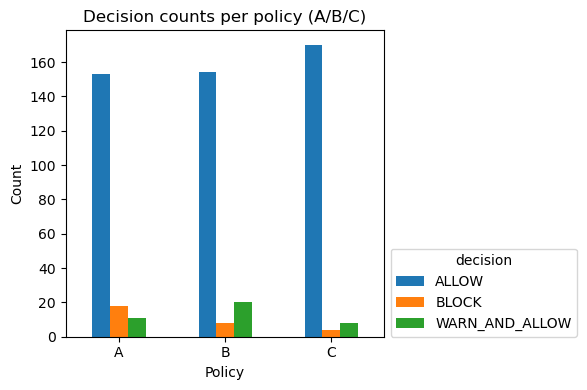

In [5]:
# Simple bar chart for decision distribution per policy
# (Uses matplotlib only, no custom colors)

ax = decision_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Count")
ax.set_title("Decision counts per policy (A/B/C)")
ax.legend(
    title="decision",    
    loc="lower left",     
    bbox_to_anchor=(1.02, 0),  
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


Average tone_score and debate_value_score per policy:


,tone_score,debate_value_score
policy,,
A,1.75,1.71
B,1.74,1.76
C,1.73,1.76


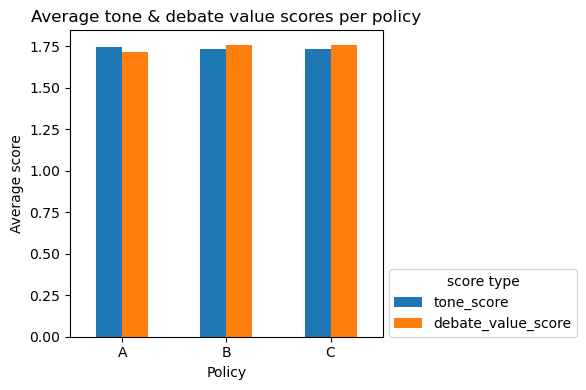

In [6]:
# ---- 2. Average scores per policy ----
score_summary = (
    merged_df
    .groupby("policy")[["tone_score", "debate_value_score"]]
    .mean()
    .sort_index()
)

print("Average tone_score and debate_value_score per policy:")
display(score_summary.round(2))

# Bar plots for scores (optional)
ax = score_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Average score")
ax.set_title("Average tone & debate value scores per policy")
ax.legend(
    title="score type",    
    loc="lower left",     
    bbox_to_anchor=(1.02, 0),  
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


In [7]:
# ---- 3. Cases where policies disagree on decision ----
# Pivot decisions to one row per sample_id
pivot_decisions = (
    merged_df
    .pivot_table(
        index="sample_id",
        columns="policy",
        values="decision",
        aggfunc="first"
    )
    .sort_index()
)

# Filter rows where not all three policies agree
disagree_mask = pivot_decisions.nunique(axis=1) > 1
disagree_samples = pivot_decisions[disagree_mask].copy()

print(f"Number of samples where policies disagree: {len(disagree_samples)}")
display(disagree_samples.head())

# Attach original text for context
disagree_with_text = (
    disagree_samples
    .reset_index()
    .merge(
        comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
        on="sample_id",
        how="left",
    )
    .sort_values("sample_id")
)

print("Disagreement cases with comment text:")
display(disagree_with_text.head(20))


Number of samples where policies disagree: 25


policy,A,B,C
sample_id,,,
1,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW
21,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW
26,BLOCK,WARN_AND_ALLOW,ALLOW
30,BLOCK,BLOCK,WARN_AND_ALLOW
79,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW


Disagreement cases with comment text:


,sample_id,A,B,C,thread_id,role,order_in_thread,text
0,1,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,1,post,0,얼마나 인기없으면 글이 안올라오냐
1,21,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,4,comment,2,괘씸해서 안받아주지 어짜피 초과학기인데 그냥 다음학기에 들어
2,26,BLOCK,WARN_AND_ALLOW,ALLOW,5,post,0,전전 3.6졸이면 ㅁㅌㅊ임? 전공 성적은 3.9 넘고 기초랑 교양에서 많이 까먹긴함
3,30,BLOCK,BLOCK,WARN_AND_ALLOW,5,comment,4,4.1졸이면 ㅁㅌㅊ임?
4,79,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,10,comment,7,공군은 그냥 공익아님?
5,80,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,10,comment,8,헌급방은 빡셈
6,81,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,10,comment,9,빡세도 육군보다는 나음
7,83,WARN_AND_ALLOW,ALLOW,ALLOW,10,comment,11,남자답게 해병대에 입대하자
8,85,BLOCK,BLOCK,WARN_AND_ALLOW,10,comment,13,공군은 사회적으로 나는 폐급이란걸 인정하는거임
9,86,BLOCK,WARN_AND_ALLOW,ALLOW,10,comment,14,라고 사회생활 안해본애가 얘기하는중 ㅋ


In [8]:
# Save disagreement cases to CSV for convenient use in slides / report
disagree_path = RESULTS_DIR / "disagreement_cases_with_text.csv"
disagree_with_text.to_csv(disagree_path, index=False, encoding="utf-8-sig")

print("Saved disagreement cases to:", disagree_path)


Saved disagreement cases to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_jayu\results\disagreement_cases_with_text.csv


In [9]:
# ---- 4. (Optional) Thread-level overview ----
# For each thread, show how many comments are blocked vs allowed under each policy.

thread_policy_summary = (
    merged_df
    .groupby(["thread_id", "policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values(["thread_id", "policy"])
)

print("Thread-level decision distribution:")
display(thread_policy_summary.head(20))

# This can be exported too if needed
thread_summary_path = RESULTS_DIR / "thread_policy_summary.csv"
thread_policy_summary.to_csv(thread_summary_path, index=False, encoding="utf-8-sig")
print("Saved thread-level summary to:", thread_summary_path)


Thread-level decision distribution:


decision,thread_id,policy,ALLOW,BLOCK,WARN_AND_ALLOW
0,1,A,2,0,1
1,1,B,2,0,1
2,1,C,3,0,0
3,2,A,7,0,0
4,2,B,7,0,0
5,2,C,7,0,0
6,3,A,8,0,0
7,3,B,8,0,0
8,3,C,8,0,0
9,4,A,6,0,1


Saved thread-level summary to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_jayu\results\thread_policy_summary.csv
